In [1]:
using OrdinaryDiffEq, LinearAlgebra
using PyPlot

┌ Info: Recompiling stale cache file /Users/alexbird/.julia/compiled/v1.1/OrdinaryDiffEq/DlSvy.ji for OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/alexbird/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184
┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/alexbird/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [93]:
function ballBounce(du, u, p, t)
    drag, g = p
    y, v = u
    du[1] = v
    du[2] = -g*sign(y) - drag*v
end


function get_ballbounce(y_init, g, v_init=0, drag=0, tT=15, grain=0.05)
    u0 = Float32[y_init, v_init]
    pars = (drag, g)
    prob = ODEProblem(ballBounce, u0, Float64[0;tT], pars)
    sol = solve(prob, Vern7(), reltol=1e-6);
    return abs.([x[1] for x in sol(0:grain:(tT-grain)).u])
end

get_ballbounce (generic function with 5 methods)

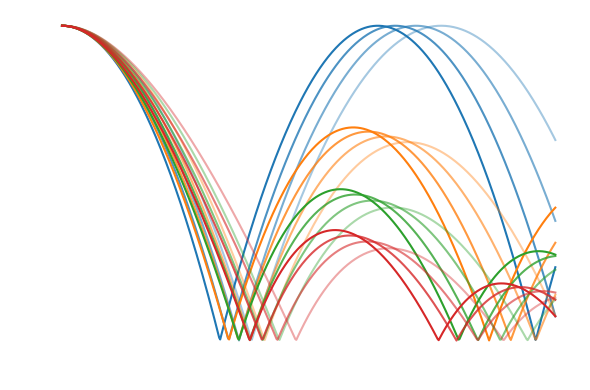

In [95]:
for (i, dd) in enumerate([0.0,0.1,0.2,0.3])
    [plot(0:0.02:(10-0.02), get_ballbounce(50, gg, 0, dd, 10, 0.02), 
            color=ColorMap("tab10")(i-1), alpha=1-(9.8-gg)/5) for gg in [9.8,8.8,7.8,6.8]]
end
gca().axis("off")
gcf().set_size_inches(6,4)
tight_layout()
savefig("/Users/alexbird/Documents/blog-attempts/ornithos.github.io/assets/img/bounceballs.svg")

In [21]:
using SeqAdaptiveIS, StatsFuns

┌ Info: Recompiling stale cache file /Users/alexbird/.julia/compiled/v1.1/SeqAdaptiveIS/gHEdt.ji for SeqAdaptiveIS [b4864a18-6930-11ea-2360-8311ae906e1d]
└ @ Base loading.jl:1184


In [111]:
function batch_ballbounce(θ, ts=[5,10,15], grain=0.05)
    max_real_time = Int(ceil(maximum(ts) / 20))
    Ŷ = Matrix{Float64}(undef, size(θ, 1), length(ts))
    for i in 1:size(θ, 1)
        if θ[i, 2] < 0
            Ŷ[i,:] .= 50
        else
            Ŷ[i,:] = get_ballbounce(50, θ[i, 1], 0, θ[i, 2], max_real_time, grain)[ts]; 
        end
    end
    return Ŷ
end

batch_ballbounce (generic function with 3 methods)

In [122]:
const test_y = get_ballbounce(50, 9.8, 0, 0.1, 10)[[10,20,30]];

log_prior(θ) = let Δ = (θ .- [8 0.2]) ./ [3 0.6]; -sum(Δ.*Δ, dims=2)[:]/2; end
function log_llh(θ, ts=[10,20,30]) 
    Ŷ = batch_ballbounce(θ, ts)
    Δ= Ŷ .- test_y'
    -sum(Δ.*Δ, dims=2)[:]/(2*0.1^2); 
end
log_joint(θ) = log_prior(θ) + log_llh(θ)

log_joint (generic function with 1 method)

In [123]:
init_smp = [(randn(1000,1)*2 .+ 8) (randn(1000,1)*0.2 .+ 0.2)]
bball_post = amis(log_joint, init_smp, 2; nepochs=5, gmm_smps=1500, IS_tilt=1.2, terminate=0.95, debug=false)
bball_post = SeqAdaptiveIS.MCPosterior(bball_post[1], bball_post[2])  # package up for ease of access
println("Effective sample size: ", SeqAdaptiveIS.eff_ss(softmax(bball_post.logW)))

Effective sample size: 1221.6390537966909


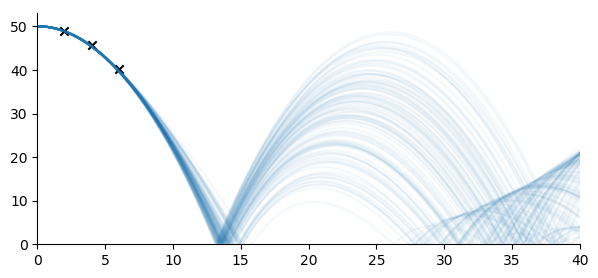

PyObject <matplotlib.collections.PathCollection object at 0x154391da0>

In [235]:
let 
    ax=gca()
    ax.set_ylim(0,53); ax.set_xlim(0,40)
    [ax.spines[s].set_visible(false) for s in ["right", "top"]]
    end; gcf().set_size_inches(7,3)
Yhat = batch_ballbounce(resample(bball_post, 100), 1:500, 0.02)
[plot((1:500)./12.5, Yhat[i, :], color=ColorMap("tab10")(0), alpha=0.05) for i in 1:100]
scatter([2,4,6], test_y, c="k", marker="x")

In [ ]:
using PyCall
anim = pyimport("matplotlib.animation")

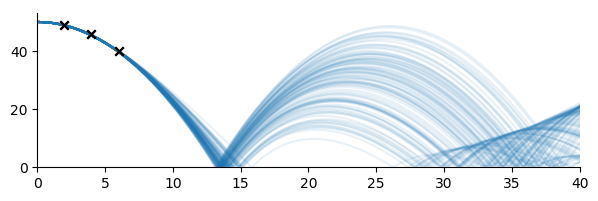

In [236]:
fig = figure()
function init_fig()
    gcf().set_size_inches(7,2)
    ax=gca()
    ax.set_ylim(0,53); ax.set_xlim(0,40)
    [ax.spines[s].set_visible(false) for s in ["right", "top"]]
    ax.scatter([2,4,6], test_y, c="k", marker="x", zorder=3)
end


function make_frame(i)
    i == 0 && return
    plot((1:500)./12.5, Yhat[i, :], color=ColorMap("tab10")(0), alpha=0.1)
end

withfig(fig) do
    myanim = anim.FuncAnimation(fig, make_frame, init_func=init_fig, frames=100, interval=100)
    gcf().set_size_inches(7,3)
    myanim.save("test2.gif", writer="imagemagick")
end

$$
\begin{bmatrix} y \\ f_* \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} K_y & K_* \\ K_*^T & K_{**}\end{bmatrix} \right) \\
f_* \mid y \sim \mathcal{N}(\mu_*, \Sigma_*) \\
\mu_* = K_*^T K_y^{-1} y \\
\Sigma_* = K_{**} - K_*^T K_y^{-1} K_*
$$

In [209]:
# Matern 3/2
matern(δ,σ=1,ρ=1) = σ*σ*(1 + √(3)*δ/ρ)*exp(-√(3)*δ/ρ)
matern_kernel(x, y, σ=1, ρ=1) = [matern(norm(x[i,:] - y[j,:]), σ, ρ) for i in 1:size(x,1), j in 1:size(y,1)]
matern_kernel_sym(x, σ=1, ρ=1) = [matern(norm(x[i,:] - x[j,:]), σ, ρ) for i in 1:size(x,1), j in 1:size(x,1)]

function matern_post_mu(Yq, Testq, Y; σ=1, ρ=1)
    Kstar = matern_kernel(Yq, Testq, σ, ρ)
    Ky = matern_kernel(Yq, Yq, σ, ρ)
    return (Kstar' * inv(Ky) * Y)
end

function matern_post_sigma(Yq, Testq; σ=1, ρ=1)
    Kstarstar = matern_kernel(Testq, Testq, σ, ρ)
    Kstar = matern_kernel(Yq, Testq, σ, ρ)
    Ky = matern_kernel(Yq, Yq, σ, ρ)
    return Kstarstar - Kstar' * inv(Ky) * Kstar
end

function posterior_matern_gp_samples(Yq, Testq, Y, N; σ=1, ρ=1)
    d = size(Testq, 1)
    μ = matern_post_mu(Yq, Testq, Y; σ=σ, ρ=ρ)
    Σ = matern_post_sigma(Yq, Testq; σ=σ, ρ=ρ)
    Σ = (Σ+Σ')/2 + 1e-12 * I
    ϵ = randn(d, N)
    μ .+ cholesky(Σ).L * ϵ
end

posterior_matern_gp_samples (generic function with 1 method)

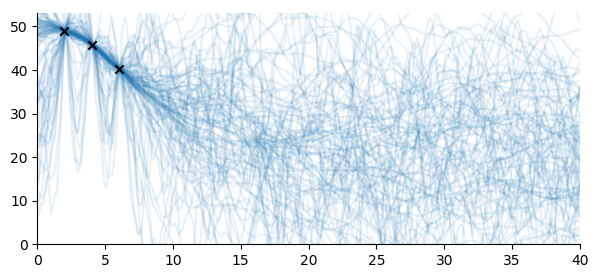

PyObject <matplotlib.collections.PathCollection object at 0x15956af28>

In [277]:
let 
    ax=gca()
    ax.set_ylim(0,53); ax.set_xlim(0,40)
    [ax.spines[s].set_visible(false) for s in ["right", "top"]]
    end; gcf().set_size_inches(7,3)
Yhat = [posterior_matern_gp_samples([2,4,6], collect(range(0, stop=40,length=500)), reshape(test_y, 3, 1) .-20, 
    10; σ=15, ρ=s)' .+ 20 for s in [1,2,3,5,7,9,12,14,16,20]]
Yhat = reduce(vcat, Yhat)[randperm(100), :]
# Yhat = posterior_matern_gp_samples([2,4,6], collect(range(0, stop=40,length=500)), reshape(test_y, 3, 1) .-20, 
#     100; σ=20, ρ=1)' .+ 20

[plot((1:500)./12.5, Yhat[i, :], color=ColorMap("tab10")(0), alpha=0.1) for i in 1:100]
scatter([2,4,6], test_y, c="k", marker="x", zorder=3)

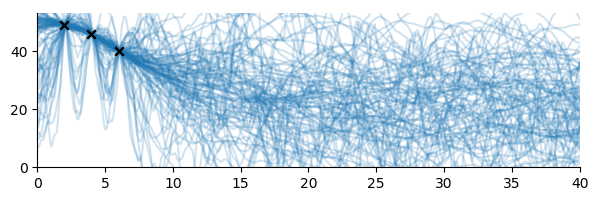

In [278]:
fig = figure()
function init_fig()
    gcf().set_size_inches(7,2)
    ax=gca()
    ax.set_ylim(0,53); ax.set_xlim(0,40)
    [ax.spines[s].set_visible(false) for s in ["right", "top"]]
    ax.scatter([2,4,6], test_y, c="k", marker="x", zorder=3)
end


function make_frame(i)
    i == 0 && return
    plot((1:500)./12.5, Yhat[i, :], color=ColorMap("tab10")(0), alpha=0.2)
#     scatter([2,4,6], test_y, c="k", marker="x")
end

withfig(fig) do
    myanim = anim.FuncAnimation(fig, make_frame, init_func=init_fig, frames=100, interval=100)
    gcf().set_size_inches(7,3)
    myanim.save("matern.gif", writer="imagemagick")
end

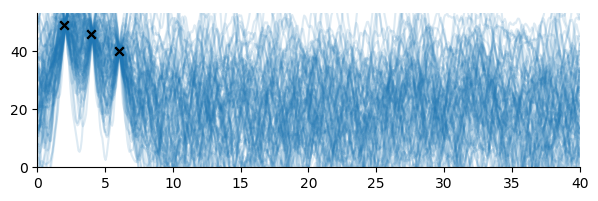

In [231]:
fig = figure()
function init_fig()
    gcf().set_size_inches(7,2)
    ax=gca()
    ax.set_ylim(0,53); ax.set_xlim(0,40)
    [ax.spines[s].set_visible(false) for s in ["right", "top"]]
    ax.scatter([2,4,6], test_y, c="k", marker="x", zorder=3)
end


function make_frame(i)
    i == 0 && return
    plot((1:500)./12.5, Yhat[i, :], color=ColorMap("tab10")(0), alpha=0.15)
end

withfig(fig) do
    myanim = anim.FuncAnimation(fig, make_frame, init_func=init_fig, frames=100, interval=100)
    gcf().set_size_inches(7,3)
    myanim.save("matern1.gif", writer="imagemagick")
end

In [105]:
tmp = open("/Users/alexbird/Downloads/TwoLeadECG/TwoLeadECG_TRAIN.txt", "r") do f
    readlines(f)
end
ecg_seqs = [parse.(Float64, split(tmp[i])[2:end]) for i in 1:length(tmp)];

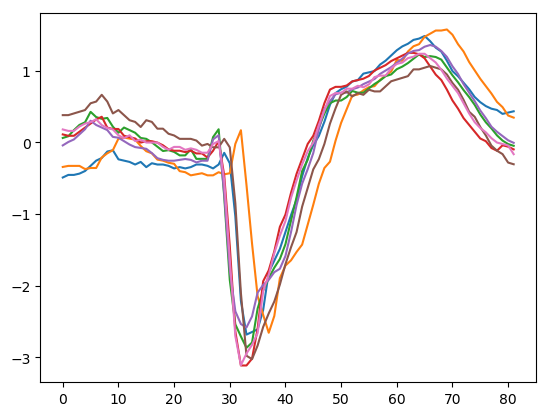

7-element Array{Array{PyCall.PyObject,1},1}:
 [PyObject <matplotlib.lines.Line2D object at 0x146f877f0>]
 [PyObject <matplotlib.lines.Line2D object at 0x1497446a0>]
 [PyObject <matplotlib.lines.Line2D object at 0x146f7f278>]
 [PyObject <matplotlib.lines.Line2D object at 0x146f7f6d8>]
 [PyObject <matplotlib.lines.Line2D object at 0x146f7fa58>]
 [PyObject <matplotlib.lines.Line2D object at 0x12f247160>]
 [PyObject <matplotlib.lines.Line2D object at 0x12f2472e8>]

In [114]:
[plot(x) for (i,x) in enumerate(ecg_seqs) if i % 3 == 0]

In [147]:
tmp = open("/Users/alexbird/Downloads/rec_2.dat", "r") do f
        readlines(f)
    end

829-element Array{String,1}:
 "'Elapsed time','I','II','III','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6'"               
 "'hh:mm:ss.mmm','mV','mV','mV','mV','mV','mV','mV','mV','mV','mV','mV','mV'"                  
 "'0:00.000',-0.052,-0.131,-0.078,0.092,0.013,-0.104,0.025,-0.169,-0.178,-0.175,-0.106,-0.081" 
 "'0:00.001',-0.037,-0.087,-0.050,0.062,0.006,-0.069,0.038,-0.125,-0.137,-0.144,-0.088,-0.062" 
 "'0:00.002',-0.033,-0.089,-0.056,0.061,0.011,-0.073,0.038,-0.122,-0.141,-0.147,-0.094,-0.066" 
 "'0:00.003',-0.034,-0.087,-0.053,0.061,0.009,-0.071,0.038,-0.125,-0.144,-0.150,-0.094,-0.069" 
 "'0:00.004',-0.037,-0.091,-0.053,0.064,0.008,-0.072,0.044,-0.131,-0.144,-0.147,-0.100,-0.069" 
 "'0:00.005',-0.037,-0.091,-0.053,0.064,0.008,-0.072,0.044,-0.137,-0.150,-0.150,-0.100,-0.075" 
 "'0:00.006',-0.034,-0.091,-0.056,0.062,0.011,-0.074,0.041,-0.137,-0.150,-0.150,-0.100,-0.075" 
 "'0:00.007',-0.037,-0.094,-0.056,0.066,0.009,-0.075,0.038,-0.137,-0.150,-0.150,-0.106,-0.075" 
 "'0:00.008

In [146]:
[parse(Float64, split(x,",")[3]) for x in split(tmp, "\r")[3:end-1]]

MethodError: MethodError: no method matching split(::Array{String,1}, ::String)
Closest candidates are:
  split(!Matched::T<:AbstractString, ::Any; limit, keepempty) where T<:AbstractString at strings/util.jl:306

In [182]:
ecgs = map(1:6) do i
    lines = open("/Users/alexbird/Downloads/rec_$i.dat", "r") do f
        readlines(f)
    end
    [parse(Float64, split(x,",")[3]) for x in lines[3:end-1]]
end

6-element Array{Array{Float64,1},1}:
 [0.455, 0.519, 0.583, 0.647, 0.725, 0.803, 0.882, 0.962, 1.031, 1.1  …  -0.076, -0.075, -0.074, -0.072, -0.072, -0.072, -0.072, -0.072, -0.064, -0.059]           
 [-0.131, -0.087, -0.089, -0.087, -0.091, -0.091, -0.091, -0.094, -0.098, -0.1  …  -0.064, -0.05, -0.042, -0.041, -0.037, -0.034, -0.034, -0.034, -0.03, -0.025]   
 [-0.077, -0.078, -0.079, -0.081, -0.078, -0.075, -0.071, -0.066, -0.066, -0.066  …  -0.053, -0.052, -0.047, -0.047, -0.047, -0.049, -0.05, -0.056, -0.059, -0.053]
 [-0.202, -0.075, -0.074, -0.078, -0.08, -0.081, -0.086, -0.084, -0.086, -0.084  …  -0.201, -0.206, -0.208, -0.209, -0.212, -0.216, -0.227, -0.241, -0.254, -0.269]
 [-0.086, -0.084, -0.083, -0.081, -0.08, -0.078, -0.074, -0.069, -0.068, -0.066  …  -0.112, -0.111, -0.112, -0.114, -0.109, -0.109, -0.109, -0.108, -0.106, -0.108]
 [0.226, 0.225, 0.224, 0.222, 0.226, 0.231, 0.233, 0.234, 0.236, 0.238  …  0.278, 0.275, 0.278, 0.281, 0.284, 0.286, 0.288, 0.284, 0.284, 0.284

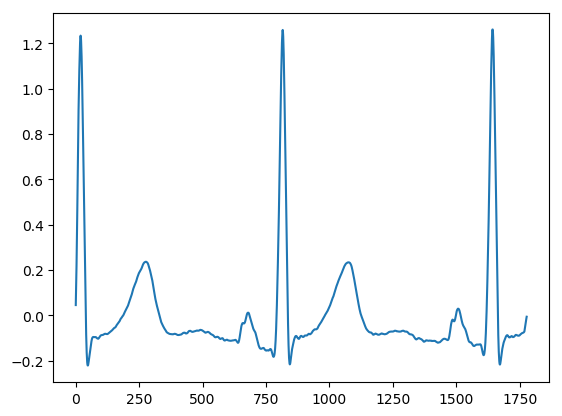

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14dc57198>

In [225]:
plot(conv(ones(10)/10, ecgs[1]))
# plot(ecgs[1])

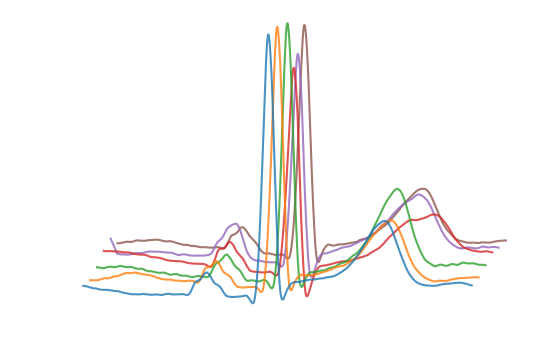

In [288]:
rngs = [410:1260, 1:850, 270:1120, 30:880, 265:1115, 210:1060]
for (i, r) in enumerate(rngs)
#     i in (3,5) && continue
    c_ecg = conv(ones(15)/15, ecgs[i])
    plot((1:length(r)) .- i*15, c_ecg[r] .- i*0.05, color=ColorMap("tab10")(6-i), alpha=0.8)
end
gca().axis("off")
gcf().set_size_inches(6,4)
savefig("/Users/alexbird/Documents/blog-attempts/ornithos.github.io/assets/img/ecg_3d.svg")

### DHO

In [282]:
using Random, Distributions
using AxUtil

┌ Info: Recompiling stale cache file /Users/alexbird/.julia/compiled/v1.1/AxUtil/zkGYv.ji for AxUtil [739e4dca-d06b-11e8-2625-cffd46b96d05]
└ @ Base loading.jl:1184


In [280]:
e_k(T, n, k) = begin; out = zeros(T, n); out[k] = 1; out; end
e_k(n, k) = e_k(Float32, n, k)
e1(T, n) = e_k(T, n, 1)
e1(n) = e_k(Float32, n, 1)

e1 (generic function with 2 methods)

In [345]:
function make_se_kernel(ts1::AbstractVector, ts2::AbstractVector, σ::Number=1)
    K = exp.(-[(t1 - t2).^2 for t1 in ts1, t2 in ts2] ./ σ.^2)
    return (K + K')/2 + 1e-9*I
end
make_se_kernel_sym(ts1::AbstractVector, σ::Number=1) = make_se_kernel(ts1, ts1, σ)
N = 40
Random.seed!(101010)
Us = cholesky(make_se_kernel_sym(1:80, 6)).L * randn(80, N);

function evaluate_state_deterministic(A, B, U, x0, timesteps)
    d = size(A, 1)
    X = zeros(d, timesteps+1)
    X[:,1] = x0
    for tt = 1:timesteps
        X[:,tt+1] = A * X[:,tt] + B * U[:,tt]
    end
    return X
end;

In [394]:
function randLDS(n_x, x0=e1(n_x), timesteps=80, U=zeros(1,80))
    A = Diagonal(sign.(randn(n_x)) .* tanh.((randn(n_x) .+3))) * svd(rand(8,8)).V
    B = rand(n_x, 1)*0.1
    C = randn(1, n_x) .+ 1
    X = evaluate_state_deterministic(A, B, U, x0, timesteps)
    return vec(C*X)
end

randLDS (generic function with 4 methods)

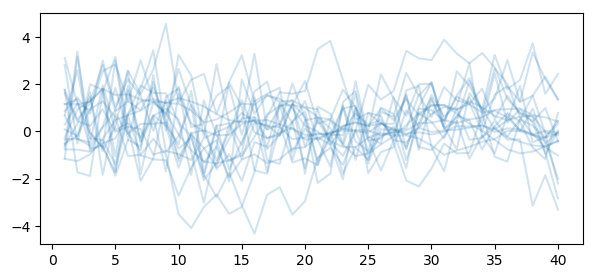

In [396]:
[plot(1:40, randLDS(8, e1(8), 40, Us[:,1:1]')[2:41], color=ColorMap("tab10")(0), alpha=0.2) for i in 1:20]
gcf().set_size_inches(7,3)
savefig("/Users/alexbird/Documents/blog-attempts/ornithos.github.io/assets/img/LDS8_weakbias5.svg")

In [289]:
# utils

trans_matrix_2d(θ, ρ) = ρ .* [cos(θ) sin(θ); -sin(θ) cos(θ)];

function evaluate_state_deterministic(A, x0, timesteps)
    d = size(A, 1)
    X = zeros(d, timesteps+1)
    X[:,1] = x0
    for tt = 1:timesteps
        X[:,tt+1] = A * X[:,tt]
    end
    return X
end;

Random.seed!(80)
const Ctrue = [1. 0. 1. 0.]
p_ρ_log = Uniform(4, 80)
p_θ = Uniform((6.75/360) * 2π, (36/360) * 2π)
x0 = [0 1 0 1]

N = 40
seq_deterministic = []
seq_noise = []

rsob = AxUtil.Random.uniform_rand_sobol(N*2, [p_θ.a, p_θ.b], [p_ρ_log.a, p_ρ_log.b])
for nn = 1:N
    A = cat([trans_matrix_2d(rsob[2*(nn-1)+i,1], exp(log(0.5)/rsob[2*(nn-1)+i,2])) for i in 1:2]..., dims=(1,2))
    Xcur = evaluate_state_deterministic(A, x0, 80-1)'*Ctrue'
    push!(seq_deterministic, Xcur[:])
    push!(seq_noise,  Xcur[:] .+ randn(80)*0.05)
end
seq_noise = Float32.(reduce(hcat, seq_noise));

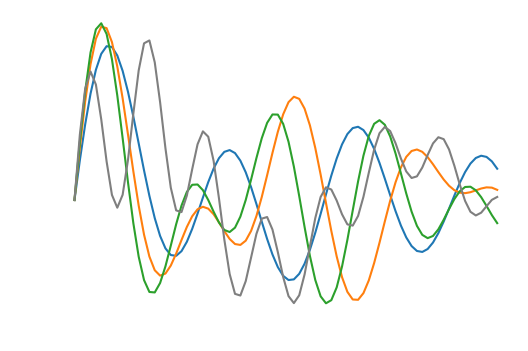

In [291]:
[plot(seq_deterministic[n], color=ColorMap("tab10")(i == 4 ? i+3 : i-1)) 
    for (i,n) in enumerate([1,3,5,10])]
gca().axis("off")
gcf().set_size_inches(6,4)
# savefig("/Users/alexbird/Documents/blog-attempts/ornithos.github.io/assets/img/2xdho.svg")

### Walmart data

In [81]:
using CSV, DataFrames, DSP

In [79]:
walmart = CSV.read("/Users/alexbird/Downloads/walmart-recruiting-store-sales-forecasting/train.csv");

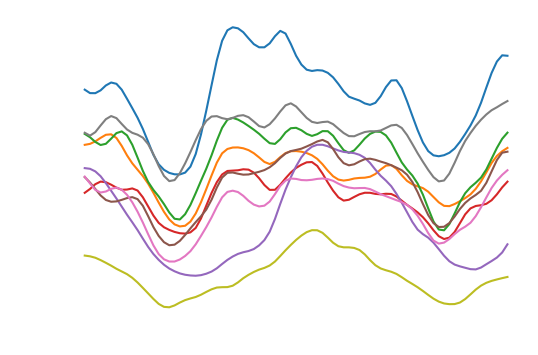

In [110]:
# [let y=sort(walmart[(walmart.Store .== i) .& (walmart.Dept .== 12), :], :Date).Weekly_Sales;
#         ysm = conv(hanning(10), y)[36:end-36]; plot(ysm); end for i in setdiff(1:10, [3,5])];
[let y=sort(walmart[(walmart.Store .== i) .& (walmart.Dept .== 12), :], :Date).Weekly_Sales;
        ysm = conv(hanning(10), y)[36:end-36]; plot(ysm); end for i in setdiff(1:15, [3,5, (11:13)..., 14])];
gca().axis("off")
gcf().set_size_inches(6,4)
savefig("/Users/alexbird/Documents/blog-attempts/ornithos.github.io/assets/img/walmart.svg")

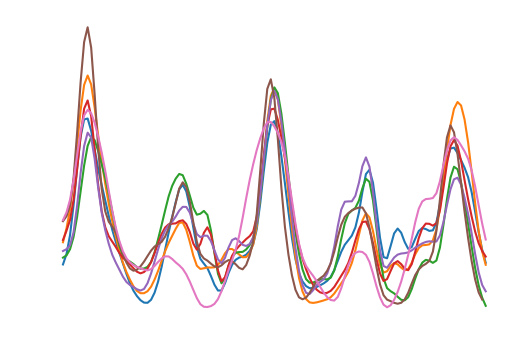

In [90]:
# 16, 2/3
wtmp = [let y=sort(walmart[(walmart.Store .== i) .& (walmart.Dept .== 36), :], :Date).Weekly_Sales;
        ysm = conv(hanning(10), y)[16:end-16]; end for i in [1,2,3,5,8,9,10]];
wtmp = [w ./ mean(w) for w in wtmp]
[plot((1:length(w)), w ) for (i,w) in enumerate(wtmp)];
gca().axis("off")
gcf().set_size_inches(6,4)

In [380]:
unique(walmart.Date)

143-element Array{Dates.Date,1}:
 2010-02-05
 2010-02-12
 2010-02-19
 2010-02-26
 2010-03-05
 2010-03-12
 2010-03-19
 2010-03-26
 2010-04-02
 2010-04-09
 2010-04-16
 2010-04-23
 2010-04-30
 ⋮         
 2012-08-10
 2012-08-17
 2012-08-24
 2012-08-31
 2012-09-07
 2012-09-14
 2012-09-21
 2012-09-28
 2012-10-05
 2012-10-12
 2012-10-19
 2012-10-26

### Mocap

In [12]:
using BSON, StatsBase, Statistics

In [3]:
cd("../mocap-mtds")

In [4]:
include("io.jl")
include("util.jl")

┌ Info: Recompiling stale cache file /Users/alexbird/.julia/compiled/v1.1/Lasso/Djwuj.ji for Lasso [b4fcebef-c861-5a0f-a7e2-ba9dc32b180a]
└ @ Base loading.jl:1184


Main.mocapio

In [5]:
# task descriptors
styles_lkp = BSON.load("data/styles_lkp")[:styles_lkp];

In [6]:
# Load in data
Usraw = BSON.load("edin_Xs_30fps.bson")[:Xs];
Ysraw = BSON.load("edin_Ys_30fps.bson")[:Ys];

In [13]:
# Standardise inputs and outputs
standardize_Y = fit(mocaputil.MyStandardScaler, reduce(vcat, Ysraw),  1)
standardize_U = fit(mocaputil.MyStandardScaler, reduce(vcat, Usraw),  1)

Ys = [mocaputil.scale_transform(standardize_Y, y[2:end, :] ) for y in Ysraw];  # (1-step ahead of u)
Us = [mocaputil.scale_transform(standardize_U, u[1:end-1,:]) for u in Usraw];  # (1-step behind y)

@assert (let c=cor(Usraw[1][1:end-1, :], Ysraw[1][2:end, :], dims=1); 
        !isapprox(maximum(abs.(c[.!isnan.(c)])), 1.0); end) "some input features perfectly correlated"

# to invert: `mocaputil.invert(standardize_Y, y)`

In [14]:
expmtdata = mocapio.ExperimentData(Ysraw, [Matrix(y') for y in Ys], 
    [Matrix(u') for u in Us], styles_lkp);

In [15]:
trainPool, validPool, testPool = mocapio.get_data(expmtdata, 1, :split, :pooled);

In [23]:
size(trainPool[1][:Y])

(64, 2951)

In [45]:
64 - _c

53

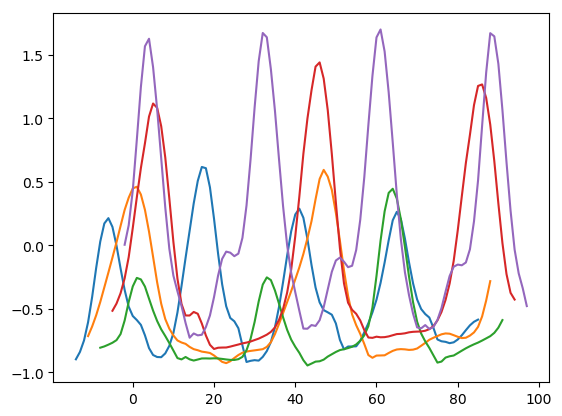

In [77]:
let 
    _c = 12
    ixs = [1,8,14,20,13]
    rngs = [10:209, 30:229, 30:229, 20:219, 24:223]
    rngs = [r[1:100] for r in rngs]
    for i in length(ixs):-1:1
#         plot((1:length(rngs[i])) .- i, trainPool[ixs[i]][:Y][_c,rngs[i]] .+ i*0.2)
        plot((1:length(rngs[i])) .- 3*i, trainPool[ixs[i]][:Y][_c,rngs[i]])
    end
end

# DHO -- codebase

In [ ]:
# utils
trans_matrix_2d(θ, ρ) = ρ .* [cos(θ) sin(θ); -sin(θ) cos(θ)];

function evaluate_state_deterministic(A, x0, timesteps)
    @assert issquare(A)
    d = size(A, 1)
    X = zeros(d, timesteps+1)
    X[:,1] = x0
    for tt = 1:timesteps
        X[:,tt+1] = A * X[:,tt]
    end
    return X
end;

const x0 = [0 1 0 -0.5]
const Ctrue = [1. 0. 1. 0.]

p_ρ_log, p_θ = Uniform(4, 80), Uniform((6.75/360) * 2π, (18/360) * 2π)
p_ρ2_log, p_θ2 = Uniform(8, 60), Uniform((22.5/360) * 2π, (36/360) * 2π)


d = 4
seq_deterministic, seq_noise = [], []

Random.seed!(80)
rsob = AxUtil.Random.uniform_rand_sobol(N, [p_θ.a, p_θ.b], [p_ρ_log.a, p_ρ_log.b], 
    [p_θ2.a, p_θ2.b], [p_ρ2_log.a, p_ρ2_log.b])
for nn = 1:N
    A1 = trans_matrix_2d(rsob[nn,1], exp(log(0.5)/rsob[nn,2]))
    A2 = trans_matrix_2d(rsob[nn,3], exp(log(0.5)/rsob[nn,4]))
    _A = cat(A1, A2, dims=[1,2])  # block diag
    Xcur = evaluate_state_deterministic(_A, x0, TS_LEN-1)'*Ctrue'
    push!(seq_deterministic, Xcur[:])
    push!(seq_noise,  Xcur[:] .+ randn(TS_LEN)*0.05)
end